# Building a Prolog-Based Gym Environment: 
## from Learning Agents to Norm Engineering


First, we install the environment as a package so we can use it later for Reinforcement learning

Note: Before using this notebook, please check paths

In [14]:
import os
# `cwd`: current directory is straightforward
cwd = os.getcwd()
# `mod_path`: According to the accepted answer and combine with future power
# if we are in the `helper_script.py`
relPath = cwd[:-23]
relPath

'/home/peter/Desktop/postdoc/Prolog-Gym'

In [15]:
import sys
import random
import numpy as np
import networkx as nx

sys.path.insert(1, relPath)
#from env_input.ConstraintsHandler import PrologHandler
import matplotlib.pyplot as plt
from environments.dataSharing.dataSharing import DataSharing
from norm_analysis.normStruct import Norm, Instance

import gymnasium as gym
import pandas as pd

os.system('pip install -e ' + relPath)

#from gymnasium.envs.registration import registry
#registry

Obtaining file:///home/peter/Desktop/postdoc/Prolog-Gym
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: environments
    Found existing installation: environments 0.0.1
    Uninstalling environments-0.0.1:
      Successfully uninstalled environments-0.0.1
  Running setup.py develop for environments


0

Environment is initialized with files contanining rules and initial data. RL agent is not yet active. The Observation and Action space are in a form off text input.  

In [16]:
env_config = {'pathToRules': relPath + '/benchmarks/dataSharing/rules.pl',
              'pathToInitialState': relPath + '/benchmarks/dataSharing/initialState.pl',
              'agentRL': None
             }
env = gym.make('environments/DataSharing-v0', env_config = env_config)

Initial state of the environment:

/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


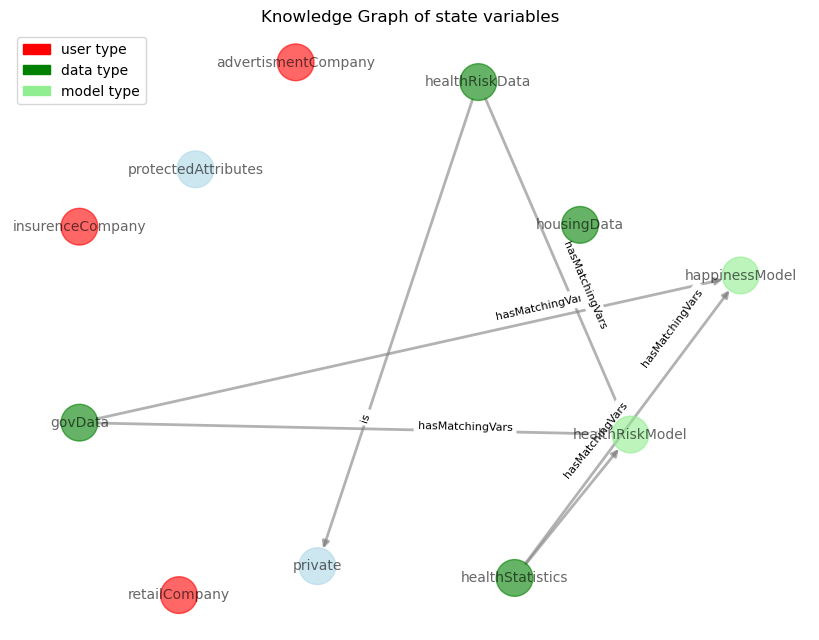

In [17]:
#plot initial state, consider:https://github.com/paulbrodersen/netgraph

G = nx.DiGraph()
init_obs, init_info = env.reset()


user_col = 'red'
data_col = 'green'
model_col = 'lightgreen'
private_col = 'lightblue'
protectedAttributes_col = 'lightblue'

for state_fact in init_info['dictState']:
    if state_fact['fact'] == 'user':
        G.add_node(state_fact['X0'], color = user_col)
    elif state_fact['fact'] == 'data':
        G.add_node(state_fact['X0'], color = data_col)
    elif state_fact['fact'] == 'model':
        G.add_node(state_fact['X0'], color = model_col)


df = env.getStateAsTriplets(init_info['dictState'])
for _, row in df.iterrows():
    G.add_edge(row['head'], row['tail'], relation=row['relation'])

G.add_node('private', color = private_col)
G.add_node('protectedAttributes', color = protectedAttributes_col)
for state_fact in init_info['dictState']:
    if state_fact['fact'] == 'private':
        G.add_edge(state_fact['X0'], 'private', relation='is')
    if state_fact['fact'] == 'hasProtectedAttributes':
        G.add_edge(state_fact['X0'], 'protectedAttributes', relation='has')


colors = nx.get_node_attributes(G, 'color').values()

pos = nx.circular_layout(G)
pos = nx.planar_layout(G)
pos = nx.spring_layout(G, k=0.95, iterations=10)
labels = nx.get_edge_attributes(G, 'relation')
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=colors, edge_color='gray', alpha=0.6, width = 2)#, connectionstyle='arc3, rad = 0.1')
#nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, edge_color='gray', alpha=0.6)#, connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph of state variables')


userArt = plt.Circle((0, 0), 0, color=user_col)
dataArt = plt.Circle((0, 0), 0, color=data_col)
modelArt = plt.Circle((0, 0), 0, color=model_col)
plt.legend([userArt, dataArt, modelArt], ['user type','data type','model type'], loc='upper left')

#plt.legend(["blue", "green"], loc="upper left")

plt.show()

Amount of terminated trajectories.

## RL agent

In [18]:
env_config = {'pathToRules': relPath + '/benchmarks/dataSharing/rules.pl',
              'pathToInitialState': relPath + '/benchmarks/dataSharing/initialState.pl',
              'agentRL': 'insurenceCompany'
             }
env = gym.make('environments/DataSharing-v0', env_config = env_config)

print("number of actions ", env.action_space.n, "for ", env_config['agentRL'])

number of actions  11 for  insurenceCompany


In [19]:
env.reset()

({'action_mask': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int8),
  'observations': array([0, 0, 0, 0, 0, 0], dtype=int8)},
 {'dictObservation': [],
  'dictState': [{'X0': 'insurenceCompany', 'fact': 'user'},
   {'X0': 'advertismentCompany', 'fact': 'user'},
   {'X0': 'retailCompany', 'fact': 'user'},
   {'X0': 'govData', 'fact': 'data'},
   {'X0': 'healthRiskData', 'fact': 'data'},
   {'X0': 'healthStatistics', 'fact': 'data'},
   {'X0': 'housingData', 'fact': 'data'},
   {'X0': 'healthRiskModel', 'fact': 'model'},
   {'X0': 'happinessModel', 'fact': 'model'},
   {'X0': 'healthRiskData', 'fact': 'private'},
   {'X0': 'govData', 'fact': 'hasPrivateAttributes'},
   {'X0': 'healthRiskData', 'fact': 'hasPrivateAttributes'},
   {'X0': 'healthRiskModel', 'fact': 'hasPrivateAttributes'},
   {'X0': 'healthRiskData',
    'X1': 'healthRiskModel',
    'fact': 'hasMatchingVars'},
   {'X0': 'govData', 'X1': 'healthRiskModel', 'fact': 'hasMatchingVars'},
   {'X0': 'healthStatistics',
    'X1':

In [20]:
from ray.rllib.algorithms.ppo import PPOConfig
import ray
ray.init(ignore_reinit_error=True, num_cpus=8)

2024-06-07 18:32:11,830	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.2


In [21]:
from ray.rllib.models import ModelCatalog
from environments.dataSharing.dataSharing import ActionMaskModel, DataSharing
ModelCatalog.register_custom_model("pa_model", ActionMaskModel)

algo = (
    PPOConfig()
    .framework('tf2', eager_max_retraces = None)
    .rollouts(num_rollout_workers=7)
    .resources(num_cpus_per_worker=1)
    .training(gamma=0.90, lr=0.001, use_critic = True, train_batch_size=5*128, kl_coeff=0.0, model={"custom_model": "pa_model", })#, entropy_coeff = 1.0) 
    .environment(env=DataSharing, env_config=env_config, auto_wrap_old_gym_envs = False)
    .build()
)

#put very big batch, low rate and a lot of updates --must work!

/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning

(raylet) [2024-06-07 18:32:21,715 E 29340 29362] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-07_18-32-10_068245_29118 is over 95% full, available space: 16678797312; capacity: 496831381504. Object creation will fail if spilling is required.
(RolloutWorker pid=29700) 2024-06-07 18:32:24,514	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(raylet) [2024-06-07 18:32:31,738 E 29340 29362] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-07_18-32-10_068245_29118 is over 95% full, available space: 16678735872; capacity: 496831381504. Object creation will fail if spilling is required.
(raylet) [2024-06-07 18:32:41,753 E 29340 29362] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-07_18-32-10_068245_29118 is over 95% full, available space: 16678690816; capacity: 496831381504. Object creation will fail if spilling is required.
(raylet) [202

In [10]:
from ray.tune.logger import pretty_print
results = []
for i in range(15):
    result = algo.train()
    results.append(result)
    print(pretty_print(result))

2024-06-07 16:34:44,498	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
/home/peter/anaconda3/envs/codeJustitia/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


agent_timesteps_total: 640
connector_metrics:
  ObsPreprocessorConnector_ms: 0.09966388581291079
  StateBufferConnector_ms: 0.02963770003545852
  ViewRequirementAgentConnector_ms: 0.3503996228414869
counters:
  num_agent_steps_sampled: 640
  num_agent_steps_trained: 640
  num_env_steps_sampled: 640
  num_env_steps_trained: 640
custom_metrics: {}
date: 2024-06-07_16-34-47
done: false
episode_len_mean: 41.111111111111114
episode_media: {}
episode_reward_max: 520.0
episode_reward_mean: 297.77777777777777
episode_reward_min: 20.0
episodes_this_iter: 9
episodes_total: 9
hostname: peter-XPS-13-7390
info:
  learner:
    default_policy:
      custom_metrics: {}
      diff_num_grad_updates_vs_sampler_policy: 74.5
      learner_stats:
        cur_kl_coeff: 0.0
        cur_lr: 0.0010000000474974513
        entropy: 0.12909166514873505
        entropy_coeff: 0.0
        kl: 0.0
        policy_loss: -0.03768983855843544
        total_loss: 1.040468454360962
        vf_explained_var: -5.030631768931

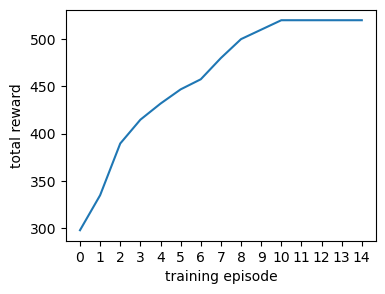

In [12]:
meanRewards = []
for res in results:
    meanRewards.append(res['episode_reward_mean'])
    #meanRewards = meanRewards + res['hist_stats']['episode_reward']


plt.figure(figsize=(4, 3))
plt.plot(meanRewards)



plt.ylabel('total reward')
plt.xlabel('training episode')
plt.xticks(np.arange(0,15,1) )
plt.show()

In [29]:
max_steps = 15
max_iter = 1000

norm = Norm()
for iter in range(max_iter):
    env.reset()
    users = env.env.handler.getAgents('user')
    traj = {}
    for user in users:
        traj[user] = Instance(user)
    
    observation, info = env.reset()
    for i in range(max_steps):
        for user in users:
            if not traj[user].terminated:
                if user == env_config['agentRL']:
                    action = algo.compute_single_action(observation)
                else:
                    action = env.env.randomAllowedAction(agent=user)
            else:
                action = {'action': 'nullAction', 'X0': user}

            new_observation, reward, terminated, truncated, info = env.step(action)
            traj[user].append(observation, action, new_observation, reward, info)
            traj[user].terminated = terminated
            traj[user].truncated = truncated
             
            observation = new_observation#.copy()
            #if terminated == True or truncated == True:
            #    break
    for user in users:
        norm.addInstance(user, iter, traj[user], unique='endStateEqualTo')

Amount of terminated trajetories

In [ ]:
terminated_count = 0
for traj_id, traj in norm.instances.items():
    #print(traj_id, traj.terminated)
    if traj.terminated == True:
        terminated_count = terminated_count + 1
        #print(traj.observation)

terminated_count/len(norm.instances)

0.18969555035128804

## Norm engineering 

Preprocessing of trajectories for Popper

In [16]:
res = env.handler.makeQuery('data(X)')
datas = [d['X'] for d in res]
res = env.handler.makeQuery('model(X)')
models = [d['X'] for d in res]
dm = datas + models

accessList = []
accessDict = {}

for traj_id, traj in norm.instances.items():
    user = traj_id[0]
    id = traj_id[1]

    accessDict[traj_id] = {}

    tmp_dict = {}
    tmp_dict['id'] = id
    tmp_dict['user'] = user
    tmp_dict.update(dict(zip(dm, [False]*len(dm))))

    for fact in traj.info[-1]['dictState']:
        if fact['fact'] == 'hasAccess' and user == fact['X0']:
            tmp_dict[fact['X1']] = True
            if fact['X1'] in models:
                accessDict[traj_id]['model'] = fact['X1']
            elif fact['X1'] in datas:
                accessDict[traj_id]['data'] = fact['X1']
            else:
                print("warning:", fact['X1'], " is not data nor model")
    accessList.append(tmp_dict)
    


import pandas as pd
accessDF = pd.DataFrame.from_dict(accessList)
accessDF.head(20)

,id,user,govData,healthRiskData,healthStatistics,housingData,newDatainsurenceCompany6,newDataretailCompany11,healthRiskModel,happinessModel
0,0,insurenceCompany,False,False,True,False,False,False,True,False
1,0,advertismentCompany,True,False,True,False,False,False,False,False
2,0,retailCompany,False,False,False,True,False,False,True,False
3,1,insurenceCompany,False,False,True,False,False,False,True,False
4,1,advertismentCompany,True,False,False,True,False,False,False,False
5,1,retailCompany,False,False,False,True,False,False,False,True
6,2,insurenceCompany,False,False,True,False,False,False,True,False
7,2,advertismentCompany,False,False,False,True,False,False,False,True
8,2,retailCompany,False,False,True,False,False,False,True,False
9,3,insurenceCompany,False,False,True,False,False,False,True,False


Some agenets failed to gain access to more than one company (max 2), hence are ommited from training data.

Examples of correct size are recorded in the environment

In [ ]:
lines = []
for traj_id,traj in norm.instances.items():
    tw_write = ''
    sid = str(traj_id[1])
    #clause = 'norm(insurenceCompany'+sid+',healthRiskData'+sid+',hospitalData'+sid+',govData'+sid+')'
    #clause = 'norm(insurenceCompany'+sid+',healthRiskData'+sid+')'



    if len(accessDict[traj_id].values()) == 2:
        argUser = traj_id[0]
        
        #arg0 = accessDict[traj_id]['data']
        #arg1 = accessDict[traj_id]['model']
        arg0, arg1 =  list(accessDict[traj_id].values())


        #clause = 'norm(insurenceCompany'+sid+','+arg0+sid+','+arg1+sid+')'
        clause = 'norm('+argUser+sid+','+arg0+sid+','+arg1+sid+')'
        if traj.terminated == True:
            #to_write = 'pos(norm(insurenceCompany'+sid+',healthRiskData'+sid+',hospitalData'+sid+',govData'+sid+',groceriesData'+sid+')).'
            to_write = 'pos(' + clause + ').'
        elif traj.terminated == False:
            to_write = 'neg(' + clause + ').'
        else:
            print("Unlabeled instance! ", id)
        lines.append(to_write)
    else:
        print("incorrect len ", traj_id, " ", list(accessDict[traj_id].values()))

with open('popper/exs.pl', 'w') as f:
    for line in sorted(lines, reverse=True):
        f.write(f"{line}\n")

print(len(lines))

incorrect len  ('advertismentCompany', 0)   ['healthStatistics']
incorrect len  ('advertismentCompany', 1)   ['govData']
incorrect len  ('advertismentCompany', 3)   ['healthStatistics']
incorrect len  ('retailCompany', 4)   ['healthRiskModel']
incorrect len  ('advertismentCompany', 5)   ['housingData']
incorrect len  ('retailCompany', 5)   ['housingData']
incorrect len  ('advertismentCompany', 6)   ['happinessModel']
incorrect len  ('retailCompany', 6)   ['healthStatistics']
incorrect len  ('advertismentCompany', 10)   ['housingData']
incorrect len  ('retailCompany', 10)   ['healthStatistics']
incorrect len  ('advertismentCompany', 11)   ['healthStatistics']
incorrect len  ('advertismentCompany', 13)   ['govData']
incorrect len  ('retailCompany', 16)   ['healthStatistics']
incorrect len  ('advertismentCompany', 19)   ['happinessModel']
incorrect len  ('advertismentCompany', 20)   ['housingData']
incorrect len  ('retailCompany', 24)   ['govData']
incorrect len  ('advertismentCompany', 2

Writing background knowledge (state variables)

In [18]:
def getEntities(env, entity_types = ['user', 'data', 'model']):
    entities = set()
    for entity in entity_types:
        for sol in env.handler.makeQuery(entity + '(X)'):
            entities.add(sol['X'])
    return entities

entities = getEntities(env)

lines = []
for traj_id, traj in norm.instances.items():
    user = traj_id[0]
    id = traj_id[1]
    if user == env_config['agentRL']:
        to_write = traj.info[-1]['formatState'].copy()
        for i in range(len(to_write)):
            for entity in entities:
                to_write[i] = to_write[i].replace(entity, entity + str(id) )



            to_write[i] = to_write[i] + '.'
        lines = lines + to_write



with open('popper/bk.pl', 'w') as f:
    for line in sorted(lines):
        f.write(f"{line}\n")

Current version of popper is not suitable to be used in Conda environment, hence we copy entire package of deprecationed version

In [35]:
from norm_analysis.Popper.popper.util import Settings, print_prog_score
from norm_analysis.Popper.popper.loop import learn_solution

Searching for common property among last states of all trajetocries.

In [20]:
#try with size 4 and if you get correct noisy ansewer then be done with it

noiz = False
settings = Settings(kbpath='/home/peter/Desktop/postdoc/Prolog-Gym/benchmarks/dataSharing/popper',
                    show_stats=False, 
                    noisy=noiz,
                    timeout = 6*600)

#/home/peter/Desktop/postdoc/normBuilding/Popper/examples/noisy-wn18rr1

#settings.max_body = 20
#settings.max_vars = 15
#settings.max_rules = 15

prog, score, stats = learn_solution(settings)
if prog != None:
    print_prog_score(prog, score, noisy=noiz)
    #settings.print_prog_score(prog, score)
else:
    print('NO SOLUTION')
if settings.show_stats:
    stats.show()

16:48:40 Generating programs of size: 2
16:48:41 Generating programs of size: 3
16:58:01 Generating programs of size: 4
17:32:28 ********************
17:32:28 New best hypothesis:
17:32:28 tp:91 fn:323 tn:1510 fp:0 size:4
17:32:28 norm(A,B,C):- performedInference(A,B,C),hasPrivateAttributes(C),hasPrivateAttributes(B).
17:32:28 ********************
17:32:29 ********************
17:32:29 New best hypothesis:
17:32:29 tp:164 fn:250 tn:1510 fp:0 size:8
17:32:29 norm(A,B,C):- performedInference(A,C,B),hasPrivateAttributes(C),hasPrivateAttributes(B).
17:32:29 norm(A,B,C):- performedInference(A,B,C),hasPrivateAttributes(C),hasPrivateAttributes(B).
17:32:29 ********************
17:54:22 TIMEOUT OF 3600 SECONDS EXCEEDED


********** SOLUTION **********
Precision:1.00 Recall:0.40 TP:164 FN:250 TN:1510 FP:0 Size:8
norm(A,B,C):- performedInference(A,C,B),hasPrivateAttributes(C),hasPrivateAttributes(B).
norm(A,B,C):- performedInference(A,B,C),hasPrivateAttributes(C),hasPrivateAttributes(B).
******************************


In [21]:
for item in prog:
    if len(prog) > 1:
        print("Warning: more than one solution")
    predicateList = []
    for inside_item in item[1]:
        #print(inside_item.__dict__.items())
        predicate = inside_item.predicate
        predicate = predicate + '(' + ','.join(inside_item.arguments) + ')'
        predicateList.append(predicate)

predicateList

['performedInference(A,B,C)',
 'hasPrivateAttributes(C)',
 'hasPrivateAttributes(B)']

New access policy is dynamically (without the need to modify env) added to the environment. 

In [24]:
max_steps = 20
max_iter = 100

norm = Norm()
for iter in range(max_iter):
    env.reset()

    #assertion of implication does not seem to be working, ask Nils

    users = env.env.handler.getAgents('user')
    traj = {}
    for user in users:
        traj[user] = Instance(user)
    
    observation, info = env.reset()

    env.env.handler.removeFact("gainAccess(X,A) :- static_gainAccess(X,A), not(hasAccess(X,A)), hasCredit(X,A)")
    env.env.handler.addFact("gainAccess(X,A) :- static_gainAccess(X,A), not(hasAccess(X,A)), hasCredit(X,A), not(hasAccess(X,B)), hasPrivateAttributes(B)")


    for i in range(max_steps):
        for user in users:
            if not traj[user].terminated:
                if user == env_config['agentRL']:
                    action = algo.compute_single_action(observation)
                else:
                    action = env.env.randomAllowedAction(agent=user)
            else:
                action = {'action': 'nullAction', 'X0': user}

            new_observation, reward, terminated, truncated, info = env.step(action)
            traj[user].append(observation, action, new_observation, reward, info)
            traj[user].terminated = terminated
            traj[user].truncated = truncated
             
            observation = new_observation#.copy()
            #if terminated == True or truncated == True:
            #    break
    for user in users:
        norm.addInstance(user, iter, traj[user], unique='endStateEqualTo')

We can observe that new access policy restricts both Random and RL agent from infering private data.

In [25]:
terminated_count = 0
for traj_id, traj in norm.instances.items():
    #print(traj_id, traj.terminated)
    if traj.terminated == True:
        terminated_count = terminated_count + 1
        #print(traj.observation)

terminated_count/len(norm.instances)

0.0